## Premier League Data Pipeline

In [1]:
# Definicion de Librerias

import requests
import pandas as pd
from configparser import ConfigParser
from utils import get_data,get_metadata_from_json,update_last_update_in_json,option_to_remove_delta_table,update_positions
from deltalake import DeltaTable,write_deltalake
from datetime import datetime,timedelta
import os
import pyarrow as pa
import great_expectations as gx
import json
import matplotlib.pyplot as plt

In [2]:
# Definicion de Variables de configuracion y de URL 
parser = ConfigParser()
parser.read('pipeline.conf')
api_key = parser.items('football-data')[0][1]
headers = {'X-AUTH-TOKEN':api_key}

url_base = 'https://api.football-data.org/v4/'

In [3]:
# Chequeo de la conexion a la API

status_code = requests.get('https://api.football-data.org/v4/matches', headers=headers).status_code
if status_code == 200:
    print('Prueba de Conexion Exitosa')
else:
    print(f'Error en la conexion, codigo: {status_code}')
    

Prueba de Conexion Exitosa


### Extraccion full de los equipos, sus squad, su informacion de la **Premier League** de la temporada 2024/2025

In [4]:
endpoint_teams = 'competitions/PL/teams'

data_PL = get_data(url_base,endpoint_teams,headers=headers)
# Leve transofrmacion de los datos para poder guardarlos en un delta lake posteriormente
data_PL_teams_df = pd.DataFrame(data_PL['teams']).drop(columns='staff')
data_PL_teams_df.head()
# sacar columna staff
data_PL_teams_df.head(3)


,area,id,name,shortName,tla,crest,address,website,founded,clubColors,venue,runningCompetitions,coach,squad,lastUpdated
0,"{'id': 2072, 'name': 'England', 'code': 'ENG',...",57,Arsenal FC,Arsenal,ARS,https://crests.football-data.org/57.png,75 Drayton Park London N5 1BU,http://www.arsenal.com,1886,Red / White,Emirates Stadium,"[{'id': 2021, 'name': 'Premier League', 'code'...","{'id': 179744, 'firstName': '', 'lastName': 'M...","[{'id': 4832, 'name': 'David Raya', 'position'...",2022-02-10T19:48:56Z
1,"{'id': 2072, 'name': 'England', 'code': 'ENG',...",58,Aston Villa FC,Aston Villa,AVL,https://crests.football-data.org/58.png,Villa Park Birmingham B6 6HE,http://www.avfc.co.uk,1872,Claret / Sky Blue,Villa Park,"[{'id': 2021, 'name': 'Premier League', 'code'...","{'id': 11616, 'firstName': '', 'lastName': 'Un...","[{'id': 3141, 'name': 'Emiliano Martínez', 'po...",2022-04-03T16:22:14Z
2,"{'id': 2072, 'name': 'England', 'code': 'ENG',...",61,Chelsea FC,Chelsea,CHE,https://crests.football-data.org/61.png,Fulham Road London SW6 1HS,http://www.chelseafc.com,1905,Royal Blue / White,Stamford Bridge,"[{'id': 2021, 'name': 'Premier League', 'code'...","{'id': 172279, 'firstName': 'Enzo', 'lastName'...","[{'id': 3189, 'name': 'Kepa Arrizabalaga', 'po...",2022-02-10T19:24:40Z


In [5]:
# Guardamos los datos en un delta lake, en la capa bronze, ya que son datos crudos
write_deltalake(
    "data_lake/bronze/teams",
    data_PL_teams_df,
    mode="overwrite"
)

teams_data_bronze_dt = DeltaTable("data_lake/bronze/teams").to_pandas().to_dict(orient='records') 


In [6]:
teams_data_bronze_dt[0]['name']

'Arsenal FC'

In [7]:
# Creacion de un DataFrame con la informacion que queremos de los equipos
# mediante list comprenhesion
teams_info = [
    dict(
            id=team_info['id'],
            team=team_info['name'],
            Stadium=team_info['venue'],
            dt=f"{team_info['coach']['firstName']} {team_info['coach']['lastName']}",
            lastUpdated=team_info['lastUpdated']
        )
for team_info in teams_data_bronze_dt]

teams_info[0:2]

[{'id': 57,
  'team': 'Arsenal FC',
  'Stadium': 'Emirates Stadium',
  'dt': ' Mikel Arteta',
  'lastUpdated': '2022-02-10T19:48:56Z'},
 {'id': 58,
  'team': 'Aston Villa FC',
  'Stadium': 'Villa Park',
  'dt': ' Unai Emery',
  'lastUpdated': '2022-04-03T16:22:14Z'}]

In [8]:
columns = ['id','team','Stadium','dt','lastUpdated']
df_2024_2025_PL = pd.DataFrame(data=teams_info,columns=columns)
# id , team , Stadium , dt , LastUpdated
df_2024_2025_PL.head(3) # -> DataFrame con la informacion de los equipos de la Premier League

,id,team,Stadium,dt,lastUpdated
0,57,Arsenal FC,Emirates Stadium,Mikel Arteta,2022-02-10T19:48:56Z
1,58,Aston Villa FC,Villa Park,Unai Emery,2022-04-03T16:22:14Z
2,61,Chelsea FC,Stamford Bridge,Enzo Maresca,2022-02-10T19:24:40Z


In [9]:
# Se sobreescriben todos los datos
write_deltalake(
    "data_lake/silver/teams_info",
    df_2024_2025_PL,
    mode="overwrite"
)

In [10]:
teams_dt = DeltaTable("data_lake/silver/teams_info").to_pandas()
teams_dt.head()

,id,team,Stadium,dt,lastUpdated
0,57,Arsenal FC,Emirates Stadium,Mikel Arteta,2022-02-10T19:48:56Z
1,58,Aston Villa FC,Villa Park,Unai Emery,2022-04-03T16:22:14Z
2,61,Chelsea FC,Stamford Bridge,Enzo Maresca,2022-02-10T19:24:40Z
3,62,Everton FC,Goodison Park,Sean Dyche,2022-02-10T19:47:42Z
4,63,Fulham FC,Craven Cottage,Marco Silva,2024-07-29T17:16:11Z


### Extraccion full de las plantillas de los equipos de la premier league de la temporada 2024/2025

Todavia no tienen un uso definido, pero sirven como datos estaticos (o de poca ocurrencia de actualizacion), ya que las plantillas solo cambian en el mercado invernal y en el mercado de verano.

In [11]:
teams_data_bronze_dt[0]['squad'][0].keys() # Leemos el DeltaTable Bronze, y extraemos info de squads
# Especificamente aca extraemos un jugador de la primera squad del primer equipo

dict_keys(['dateOfBirth', 'id', 'name', 'nationality', 'position'])

In [12]:
# Guardamos la informacion que necesitemos de todos los equipos
# List Comprenhension anidado
    
squads = [
    dict(id_team=team['id'],
         squad=[
            dict(
                id=player_data['id'],
                name=player_data['name'],
                position=player_data['position'],
                nationality=player_data['nationality'],
                dateOfBirth=player_data['dateOfBirth']
                )
            for player_data in team['squad']
                ]
        )
    for team in teams_data_bronze_dt
]

# Este dataframe contiene por cada equipo -> (id del equipo, lista de jugadores)    
squads[0]['squad'][5:7]

[{'id': 133512,
  'name': 'Riccardo Calafiori',
  'position': 'Centre-Back',
  'nationality': 'Italy',
  'dateOfBirth': '2002-05-19'},
 {'id': 112948,
  'name': 'Fabio Vieira',
  'position': 'Attacking Midfield',
  'nationality': 'Portugal',
  'dateOfBirth': '2000-05-30'}]

In [13]:
df_squads = pd.DataFrame(data=squads)
df_squads.head(10)
# Cada registro muestra el id_team y una lista de jugadores


,id_team,squad
0,57,"[{'id': 4832, 'name': 'David Raya', 'position'..."
1,58,"[{'id': 3141, 'name': 'Emiliano Martínez', 'po..."
2,61,"[{'id': 3189, 'name': 'Kepa Arrizabalaga', 'po..."
3,62,"[{'id': 3309, 'name': 'Jordan Pickford', 'posi..."
4,63,"[{'id': 3174, 'name': 'Bernd Leno', 'position'..."
5,64,"[{'id': 1795, 'name': 'Alisson', 'position': '..."
6,65,"[{'id': 3222, 'name': 'Ederson', 'position': '..."
7,66,"[{'id': 7544, 'name': 'André Onana', 'position..."
8,67,"[{'id': 3310, 'name': 'Nick Pope', 'position':..."
9,73,"[{'id': 3086, 'name': 'Guglielmo Vicario', 'po..."


In [14]:
# Normalizamos el json para que cada jugador sea un registro con su respectivo id_team, y sea mas
df_squads = pd.json_normalize(data=squads,record_path='squad',meta='id_team')
df_squads.head()

,id,name,position,nationality,dateOfBirth,id_team
0,4832,David Raya,Goalkeeper,Spain,1995-09-15,57
1,5530,Aaron Ramsdale,Goalkeeper,England,1998-05-14,57
2,247644,Ayden Heaven,Centre-Back,England,2006-09-22,57
3,188476,Ethan Nwaneri,Attacking Midfield,England,2007-03-21,57
4,147286,Jakub Kiwior,Left-Back,Poland,2000-02-15,57


In [15]:
path_silver_squads = "data_lake/silver/squads"
schema_silver_squads = pa.schema([
        pa.field("id",pa.int64()),
        pa.field("name",pa.string()),
        pa.field("position",pa.string()),
        pa.field("nationality",pa.string()),
        pa.field("dateOfBirth",pa.string()),
        pa.field("id_team",pa.int64())                       
    ])
if os.path.exists(path_silver_squads) == False:
    DeltaTable.create(
        "data_lake/silver/squads",
        schema=schema_silver_squads,
        configuration={
            "delta.deletedFileRetentionDuration": "interval 7 day",
            "delta.logRetentionDuration": "interval 7 day",
            "delta.autoOptimize.optimizeWrite": "true"
        },
        partition_by="id_team"
    )
    print("Delta Table Creada")
else:
    option_to_remove_delta_table(path_silver_squads)

In [16]:
# Guardar en deltalake particionado por id_team
# Cada parquet contiene la plantilla del equipo
if os.path.exists(path_silver_squads):
    write_deltalake(
        "data_lake/silver/squads",
        df_squads,
        mode="overwrite"
    )
else:
    print("Delta table no existe")

### Extraccion full de los partidos de la premier league de la temporada 2024/2025
Para tener un dataset completo de la temporada 2024/2025 de la premier league, se extraen todos los partidos de la temporada.

In [17]:
endpoint_matches = 'competitions/PL/matches'
data_matches = get_data(url_base,endpoint_matches,headers=headers)['matches']
data_matches[0]

{'area': {'id': 2072,
  'name': 'England',
  'code': 'ENG',
  'flag': 'https://crests.football-data.org/770.svg'},
 'competition': {'id': 2021,
  'name': 'Premier League',
  'code': 'PL',
  'type': 'LEAGUE',
  'emblem': 'https://crests.football-data.org/PL.png'},
 'season': {'id': 2287,
  'startDate': '2024-08-16',
  'endDate': '2025-05-25',
  'currentMatchday': 2,
  'winner': None},
 'id': 497410,
 'utcDate': '2024-08-16T19:00:00Z',
 'status': 'FINISHED',
 'matchday': 1,
 'stage': 'REGULAR_SEASON',
 'group': None,
 'lastUpdated': '2024-08-25T05:21:13Z',
 'homeTeam': {'id': 66,
  'name': 'Manchester United FC',
  'shortName': 'Man United',
  'tla': 'MUN',
  'crest': 'https://crests.football-data.org/66.png'},
 'awayTeam': {'id': 63,
  'name': 'Fulham FC',
  'shortName': 'Fulham',
  'tla': 'FUL',
  'crest': 'https://crests.football-data.org/63.png'},
 'score': {'winner': 'HOME_TEAM',
  'duration': 'REGULAR',
  'fullTime': {'home': 1, 'away': 0},
  'halfTime': {'home': 0, 'away': 0}},
 '

In [18]:

data_matches_pd = pd.DataFrame(data_matches).drop(columns=['odds','group','season'])

data_matches_pd = pd.concat([data_matches_pd,pd.json_normalize(data=data_matches_pd['score'])],axis=1)

mapa_imp = {
    'winner':'-',
    'goals_home':'0',
    'goals_away':'0'
}

data_matches_pd = (
    data_matches_pd
    .drop(columns=['halfTime.home','halfTime.away','score'])
    .rename(columns={'fullTime.home':'goals_home','fullTime.away':'goals_away'})
    .fillna(mapa_imp)
)
data_matches_pd['referees'] = data_matches_pd['referees'].apply(lambda x: 'no referee yet' if x == [] else x[0]['name'])
data_matches_pd['goals_home'] = data_matches_pd['goals_home'].astype(int)
data_matches_pd['goals_away'] = data_matches_pd['goals_away'].astype(int)


print(data_matches_pd.columns)
data_matches_pd.info()
data_matches_pd.head()['referees'][0]

Index(['area', 'competition', 'id', 'utcDate', 'status', 'matchday', 'stage',
       'lastUpdated', 'homeTeam', 'awayTeam', 'referees', 'winner', 'duration',
       'goals_home', 'goals_away'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   area         380 non-null    object
 1   competition  380 non-null    object
 2   id           380 non-null    int64 
 3   utcDate      380 non-null    object
 4   status       380 non-null    object
 5   matchday     380 non-null    int64 
 6   stage        380 non-null    object
 7   lastUpdated  380 non-null    object
 8   homeTeam     380 non-null    object
 9   awayTeam     380 non-null    object
 10  referees     380 non-null    object
 11  winner       380 non-null    object
 12  duration     380 non-null    object
 13  goals_home   380 non-null    int32 
 14  goals_away   380 n

'Robert Jones'

In [19]:
# Guardamos los datos en un delta lake, en la capa bronze, ya que son datos casi crudos
write_deltalake(
    "data_lake/bronze/all_matches",
    data_matches_pd,
    mode="overwrite"
)

data_matches_dt = DeltaTable("data_lake/bronze/all_matches").to_pandas()
data_matches_dt.head(3)

,area,competition,id,utcDate,status,matchday,stage,lastUpdated,homeTeam,awayTeam,referees,winner,duration,goals_home,goals_away
0,"{'code': 'ENG', 'flag': 'https://crests.footba...","{'code': 'PL', 'emblem': 'https://crests.footb...",497410,2024-08-16T19:00:00Z,FINISHED,1,REGULAR_SEASON,2024-08-25T05:21:13Z,{'crest': 'https://crests.football-data.org/66...,{'crest': 'https://crests.football-data.org/63...,Robert Jones,HOME_TEAM,REGULAR,1,0
1,"{'code': 'ENG', 'flag': 'https://crests.footba...","{'code': 'PL', 'emblem': 'https://crests.footb...",497411,2024-08-17T11:30:00Z,FINISHED,1,REGULAR_SEASON,2024-08-25T05:21:13Z,{'crest': 'https://crests.football-data.org/34...,{'crest': 'https://crests.football-data.org/64...,Tim Robinson,AWAY_TEAM,REGULAR,0,2
2,"{'code': 'ENG', 'flag': 'https://crests.footba...","{'code': 'PL', 'emblem': 'https://crests.footb...",497412,2024-08-17T14:00:00Z,FINISHED,1,REGULAR_SEASON,2024-08-25T05:21:13Z,{'crest': 'https://crests.football-data.org/57...,{'crest': 'https://crests.football-data.org/76...,Jarred Gillett,HOME_TEAM,REGULAR,2,0


### Extraccion incremental de los partidos de la premier league de la temporada 2024/2025
El archivo metadata.json guarda la fecha de la ultima carga de partidos finalizados, para poder hacer una extraccion incremental de los partidos de la premier league de la temporada 2024/2025

In [20]:
# update_last_update_in_json("metadata/metadata.json","2024-08-15T00:00:00Z") # Para actualizar un dia antes de la temporada
print(f"Ultima actualizacion { get_metadata_from_json("metadata/metadata.json") }")


Ultima actualizacion 2024-08-15T00:00:00Z


In [4]:
# EJECUTAR PARA OBTENER LOS NUEVOS DATOS DESDE LA ULTIMA FECHA DE ACTUALIZACION HASTA ESTE MOMENTO

endpoint_matches = 'competitions/PL/matches'
# Aca hago un get a los partidos que ya terminaron, y que cumplen que son mayores a la fecha que esta en el metadata.json
last_date = get_metadata_from_json("metadata/metadata.json")
last_date = datetime.strptime(last_date,'%Y-%m-%dT%H:%M:%SZ').strftime('%Y-%m-%d')
# Recolectamos solo año-mes-dia
params = {
    'dateFrom':last_date,
    # ATENCION
    'dateTo':datetime.now().strftime('%Y-%m-%d') 
    #'dateTo' :"2024-12-12" # Fecha simulada de pruebas, se cargaran los partidos desde el dateFrom hasta el dateTo
    
}

played_matches = get_data(url_base,endpoint_matches,headers=headers,params=params)
played_matches['matches'][-1].keys()

dict_keys(['area', 'competition', 'season', 'id', 'utcDate', 'status', 'matchday', 'stage', 'group', 'lastUpdated', 'homeTeam', 'awayTeam', 'score', 'odds', 'referees'])

In [5]:
# Procesa datos de los partidos jugados que se van a cargar en el delta lake
played_matches_df = [
    dict(
            matchday=match['matchday'],
            id=match['id'],
            status=match['status'],
            date=match['utcDate'],
            home=match['homeTeam']['id'],
            away=match['awayTeam']['id'],
            goals_home=match['score']['fullTime']['home'],
            goals_away=match['score']['fullTime']['away']
    )
    for match in played_matches['matches']
]    

played_matches_df= pd.DataFrame(data=played_matches_df)

played_matches_df = played_matches_df.query('status == "FINISHED"') 

played_matches_df.fillna(0,inplace=True)
played_matches_df.tail()
# Aca tendriamos los partidos ya jugados que no se inseraron en el delta lake


,matchday,id,status,date,home,away,goals_home,goals_away
5,2,497428,FINISHED,2024-08-24T14:00:00Z,73,62,4,0
6,2,497421,FINISHED,2024-08-24T16:30:00Z,58,57,0,2
7,2,497420,FINISHED,2024-08-25T13:00:00Z,1044,67,1,1
8,2,497429,FINISHED,2024-08-25T13:00:00Z,76,61,2,6
9,2,497425,FINISHED,2024-08-25T15:30:00Z,64,402,2,0


In [6]:
played_matches_df['date'].max() # Fecha maxima deL df, osea de los partidos jugados

'2024-08-25T15:30:00Z'


<h2> <font color='red'> Ejecutar solo si queres restaurar los datos de los partidos jugados!!! </font> </h2>



In [24]:
# Creacion de tabla delta particionada por matchday
schema = pa.schema([
    pa.field('matchday',pa.int64()),
    pa.field('id',pa.int64()),
    pa.field('status',pa.string()),
    pa.field('date',pa.string()),
    pa.field('home',pa.int64()),
    pa.field('away',pa.int64()),
    pa.field('goals_home',pa.int64()),
    pa.field('goals_away',pa.int64())
])

# Verificaciones para no tener errores
path_played_matches = "data_lake/silver/played_matches"

if os.path.exists(path_played_matches) == False:
    # Se crea la tabla delta particionada por matchday, esta estara vacia en el momento de su creacion
    # Creacion de tabla vacia
    DeltaTable.create(
        path_played_matches,
        schema=schema,
        partition_by=["matchday"],
        configuration={
            "delta.deletedFileRetentionDuration": "interval 7 day", # Se eliminan los archivos ya desactualizados
            "delta.logRetentionDuration": "interval 7 day", # Se eliminan los logs ya desactualizados
            "delta.autoOptimize.optimizeWrite": "true" # Optimizacion de escritura
        }
    )
    
else: # Si la carpeta ya existe, se pregunta si se desea eliminar
        option_to_remove_delta_table(path_played_matches)
        if os.path.exists(path_played_matches) == False:
            update_last_update_in_json("metadata/metadata.json","2024-08-15T00:00:00Z") # actualiza a dia antes de la temporada
        
               
    

In [7]:
# Insercion de datos al delta lake
try:
    if played_matches_df.empty:
        raise Exception("No hay datos para cargar")
    
    if os.path.exists("data_lake/silver/played_matches") == False:
        raise Exception("No existe la tabla played_matches")
    
    dt = DeltaTable("data_lake/silver/played_matches")

    new_data_pa = pa.Table.from_pandas(played_matches_df)
    (
        dt.merge(
            source=new_data_pa,
            source_alias="source",
            target_alias="target",
            predicate="source.id = target.id"
        )
        .when_not_matched_insert_all() 
        .execute()
    ) 
    # Se actualiza la metadata una vez insertados los datos
    update_last_update_in_json("metadata/metadata.json",played_matches_df['date'].max())
except Exception as e:
    print(f"Error: {e}")

In [9]:
# Aca podes ver los partidos jugados en la fecha que se indique
matchday = 2 # para ejemplo
try:
    ls = os.listdir(f"data_lake/silver/played_matches/matchday={matchday}/")
    df = pd.read_parquet(f"data_lake/silver/played_matches/matchday={matchday}/{ls[-1]}") # Muestra el ultimo parquet
except FileNotFoundError:
    print("No se encontro el directorio")

df.sort_values(by='date',ascending=False) 

,id,status,date,home,away,goals_home,goals_away
5,497421,FINISHED,2024-08-24T16:30:00Z,58,57,0,2
0,497426,FINISHED,2024-08-24T14:00:00Z,65,349,4,1
1,497427,FINISHED,2024-08-24T14:00:00Z,340,351,0,1
2,497424,FINISHED,2024-08-24T14:00:00Z,63,338,2,1
4,497428,FINISHED,2024-08-24T14:00:00Z,73,62,4,0
6,497423,FINISHED,2024-08-24T14:00:00Z,354,563,0,2
3,497422,FINISHED,2024-08-24T11:30:00Z,397,66,2,1


In [10]:
df = pd.read_parquet(f"data_lake/silver/played_matches")


print(f"Se cargaron {len(df)} partidos jugados en total")
df.tail(3) # Muestra los ultimos partidos jugados cargados en el delta lake

Se cargaron 20 partidos jugados en total


,id,status,date,home,away,goals_home,goals_away,matchday
17,497428,FINISHED,2024-08-24T14:00:00Z,73,62,4,0,2
18,497421,FINISHED,2024-08-24T16:30:00Z,58,57,0,2,2
19,497423,FINISHED,2024-08-24T14:00:00Z,354,563,0,2,2


### Data Testing

Con la libreria **Great Expectations**

In [11]:
df_played_matches_dt = gx.read_parquet("data_lake/silver/played_matches") # Un dataframe
type(df) # -> great_expectations.dataset.pandas_dataset.PandasDataset
df_played_matches_dt.head(3) # Es un dataframe de great_expectations, que es como un pandas, pero con mas funcionalidades


,id,status,date,home,away,goals_home,goals_away,matchday
0,497411,FINISHED,2024-08-17T11:30:00Z,349,64,0,2,1
1,497417,FINISHED,2024-08-18T13:00:00Z,402,354,2,1,1
2,497418,FINISHED,2024-08-18T15:30:00Z,61,65,0,2,1


In [12]:
# Verifica que todos los partidos cargados esten en estado FINISHED
x = df_played_matches_dt.expect_column_values_to_be_in_set(column='status',value_set=['FINISHED'])
if x['success']:
    print("Todos los partidos cargados estan en estado FINISHED")
else:
    print(f"Hay {x['result']['unexpected_count']} partidos que no estan en estado FINISHED")
    

Todos los partidos cargados estan en estado FINISHED


In [13]:
# Verificar que los id de los partidos sean unicos
if df_played_matches_dt.expect_column_values_to_be_unique(column='id')['success']:
    print("Los id de los partidos son unicos")

Los id de los partidos son unicos


### Tabla de Posiciones actualizada

In [14]:
df_teams_to_join = pd.read_parquet("data_lake/silver/teams_info")
# Obtenemos el DataFrame de los equipos con su info necesaria para el join
# id y el nombre del equipo
df_teams_to_join = df_teams_to_join[['id','team']] 
df_teams_to_join.head(3)

df_played_matches_dt.head(3) # -> DataFrame con los partidos jugados home y away contienen el id del equipo 

,id,status,date,home,away,goals_home,goals_away,matchday
0,497411,FINISHED,2024-08-17T11:30:00Z,349,64,0,2,1
1,497417,FINISHED,2024-08-18T13:00:00Z,402,354,2,1,1
2,497418,FINISHED,2024-08-18T15:30:00Z,61,65,0,2,1


In [15]:
# Leemos df de partidos jugados y lo unimos con el df de df_teams_to_join que contiene el id y el nombre del equipo

df_played_matches_dt = gx.read_parquet("data_lake/silver/played_matches")
# Join del equipo local
df_played_matches_dt_joined = df_played_matches_dt.merge(
    df_teams_to_join,
    left_on='home',
    right_on='id',
    how='left',
    suffixes=('','_home')
)

df_played_matches_dt_joined.rename(columns={'team':'home_team'},inplace=True)
# Join del equipo visitante
df_played_matches_dt_joined = df_played_matches_dt_joined.merge(
    df_teams_to_join,
    left_on='away',
    right_on='id',
    how='left',
    suffixes=('','_away')
)

# Limpieza de columnas
df_played_matches_dt_joined.rename(columns={'team':'away_team'},inplace=True)
df_played_matches_dt_joined.drop(columns=['id_home','id_away','home','away'],inplace=True)
df_played_matches_dt_joined.tail()

,id,status,date,goals_home,goals_away,matchday,home_team,away_team
15,497424,FINISHED,2024-08-24T14:00:00Z,2,1,2,Fulham FC,Leicester City FC
16,497422,FINISHED,2024-08-24T11:30:00Z,2,1,2,Brighton & Hove Albion FC,Manchester United FC
17,497428,FINISHED,2024-08-24T14:00:00Z,4,0,2,Tottenham Hotspur FC,Everton FC
18,497421,FINISHED,2024-08-24T16:30:00Z,0,2,2,Aston Villa FC,Arsenal FC
19,497423,FINISHED,2024-08-24T14:00:00Z,0,2,2,Crystal Palace FC,West Ham United FC


In [16]:
# Creada tabla de posiciones para la Premier League
positions = pd.DataFrame(columns=['team', 'points', 'goals_for', 'goals_against', 'goal_difference'])

df_played_matches_json = df_played_matches_dt_joined.to_json(orient='records')

for indice,row in df_played_matches_dt_joined.iterrows():
    
    home_team = row["home_team"]
    away_team = row["away_team"]
    goals_home = row["goals_home"]
    goals_away = row["goals_away"]
    
    # Update Positions toma la tabla de posiciones, el equipo, los goles a favor, los goles en contra y los puntos que se le dara
    if goals_home > goals_away: # En caso de que el equipo home gane
        update_positions(positions,home_team,goals_home,goals_away,3)
        update_positions(positions,away_team,goals_away,goals_home,0)
    elif goals_home < goals_away: # En caso de que el equipo away gane
        update_positions(positions,home_team,goals_home,goals_away,0)
        update_positions(positions,away_team,goals_away,goals_home,3)
    else: # En caso de empate
        update_positions(positions,home_team,goals_home,goals_away,1)
        update_positions(positions,away_team,goals_away,goals_home,1)
        
#La tabla ordenada de mas a menos puntos y si coinciden puntos, ordenar por goles de diferencia
positions.sort_values(by=['points','goal_difference'],ascending=False,inplace=True) 

# Resetea indice de registros de pandas ya que en el paso anterior se ordenaron los registros
positions.reset_index(drop=True,inplace=True,)

positions

,team,points,goals_for,goals_against,goal_difference
0,Manchester City FC,6,6,1,5
1,Liverpool FC,6,4,0,4
2,Arsenal FC,6,4,0,4
3,Brighton & Hove Albion FC,6,5,1,4
4,Tottenham Hotspur FC,4,5,1,4
5,Nottingham Forest FC,4,2,1,1
6,Newcastle United FC,4,2,1,1
7,Chelsea FC,3,6,4,2
8,West Ham United FC,3,3,2,1
9,Manchester United FC,3,2,2,0


In [34]:
# Escribimos la tabla de posiciones en la capa gold, ya que son datos preparados para ser consumidos por el usuario/dashboard
write_deltalake(
    "data_lake/gold/positions",
    positions,
    mode="overwrite"    
)

In [35]:
positions_dt = DeltaTable("data_lake/gold/positions").to_pandas()
positions_dt.head()

,team,points,goals_for,goals_against,goal_difference
0,Manchester City FC,6,6,1,5
1,Arsenal FC,6,4,0,4
2,Brighton & Hove Albion FC,6,5,1,4
3,Tottenham Hotspur FC,4,5,1,4
4,Nottingham Forest FC,4,2,1,1


### Datos de jugadores, edad y paises

In [36]:
# Verificar edad media de los jugadores
df_squads = pd.read_parquet("data_lake/silver/squads")

df_squads['age'] = round((datetime.now() - pd.to_datetime(df_squads['dateOfBirth'])).dt.days // 365)

print(f" Edad media de jugadores  {df_squads['age'].mean()}")
df_squads


 Edad media de jugadores  25.377926421404684


,id,name,position,nationality,dateOfBirth,id_team,age
0,3221,Neto,Goalkeeper,Brazil,1989-07-19,1044,35.0
1,82135,Mark Travers,Goalkeeper,Ireland,1999-05-18,1044,25.0
2,131127,Will Dennis,Goalkeeper,England,2000-07-10,1044,24.0
3,191727,Dean Huijsen,Centre-Back,Spain,2005-04-14,1044,19.0
4,177305,Dango Ouattara,Left Winger,Burkina Faso,2002-02-11,1044,22.0
...,...,...,...,...,...,...,...
594,133770,Chem Campbell,Attacking Midfield,Wales,2002-12-30,76,21.0
595,133553,Boubacar Traoré,Defensive Midfield,Mali,2001-08-20,76,23.0
596,131115,Luke Cundle,Central Midfield,England,2002-04-26,76,22.0
597,125151,Fábio Silva,Centre-Forward,Portugal,2002-07-19,76,22.0


In [37]:
# Agrupamos a los jugadores por edad y contamos cuantos jugadores hay por cada edad
players_per_age = df_squads.groupby(['age']).agg({'id':'count'}).rename(columns={'id':'Players per Age'})

write_deltalake(
    "data_lake/gold/players_per_age",
    players_per_age,
    mode="overwrite",
    partition_by=["age"]
)

In [38]:
# Leemos los datos de los jugadores por edad, proveninentes del delta lake recien creado
players_per_age_dt = DeltaTable("data_lake/gold/players_per_age").to_pandas().sort_values(by='age')
players_per_age_dt.head(3)


,Players per Age,age
0,8,17.0
1,21,18.0
9,22,19.0


<Axes: title={'center': 'Players per Age'}, xlabel='Age', ylabel='Players per Age'>

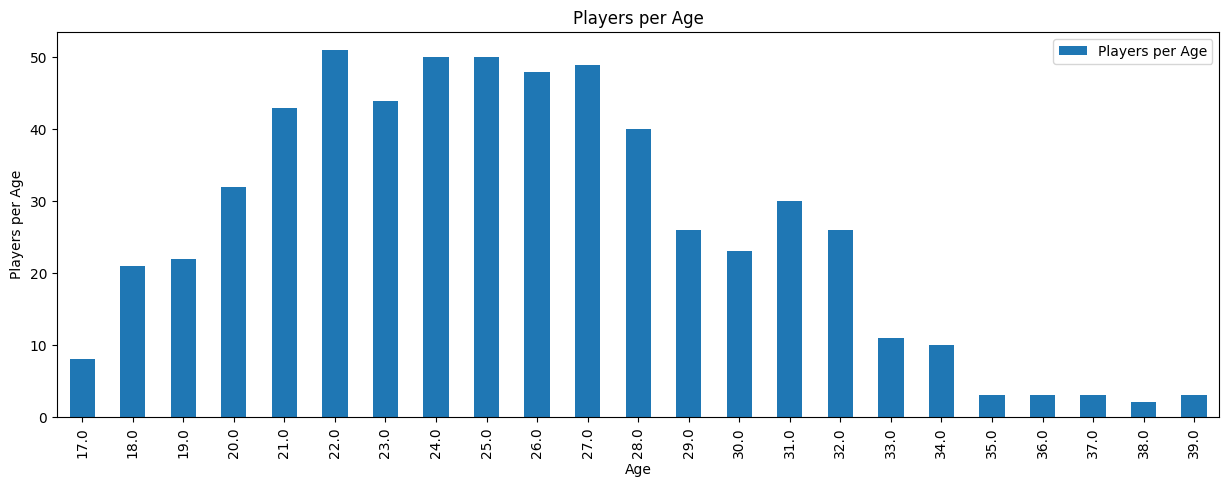

In [39]:
# Con los datos extraidos del datalake
# podemos ver por ejemplo, la cantidad de jugadores por edad, mediante un grafico de matplotlib
players_per_age_dt.plot(kind='bar',figsize=(15,5),x='age',y='Players per Age',xlabel='Age',ylabel='Players per Age',title='Players per Age')

In [40]:
# Lo que hace esto es mostrar la cantidad de jugadores por nacionalidad, en este caso se muestran los 10 paises con mas jugadores jugando actualmente en la PL
(
    df_squads.groupby('nationality')
             .agg({'id':'count'})
             .rename(columns={'id':'Players per Nationality'})
             .sort_values(by='Players per Nationality',ascending=False)
             .head(10)
)         


,Players per Nationality
nationality,
England,215
Brazil,31
Portugal,27
France,23
Netherlands,20
Ireland,19
Argentina,16
Spain,16
Denmark,15
